#### Import needed

In [1]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import os,sys
import re
import matplotlib.pyplot as plt

#### Adding  stop_word

In [2]:
stop_words = [
"a", "about", "above", "across", "after", "afterwards", 
"again", "all", "almost", "alone", "along", "already", "also",    
"although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another", "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "as", "at", "be", "became", "because", "become","becomes", "becoming", "been", "before", "behind", "being", "beside", "besides", "between", "beyond", "both", "but", "by","can", "cannot", "cant", "could", "couldnt", "de", "describe", "do", "done", "each", "eg", "either", "else", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "find","for","found", "four", "from", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "i", "ie", "if", "in", "indeed", "is", "it", "its", "itself", "keep", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mine", "more", "moreover", "most", "mostly", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next","no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own", "part","perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "she", "should","since", "sincere","so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "take","than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they",
"this", "those", "though", "through", "throughout",
"thru", "thus", "to", "together", "too", "toward", "towards",
"under", "until", "up", "upon", "us",
"very", "was", "we", "well", "were", "what", "whatever", "when",
"whence", "whenever", "where", "whereafter", "whereas", "whereby",
"wherein", "whereupon", "wherever", "whether", "which", "while", 
"who", "whoever", "whom", "whose", "why", "will", "with",
"within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
]

In [3]:
# X --> list of strings where each string contain one text document.
# Y --> corresponding categories
X  =[] 
Y = []
for category in os.listdir("20_newsgroups1"):
    for document in os.listdir("20_newsgroups1/"+category):
        with open("20_newsgroups1/"+category+'/'+document, "r") as f:
            X.append(f.read())
            Y.append(category)

### Spliting in training and testing Data

In [4]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=0)

## Build Vocab

In [5]:
vocab={}
'''
    \W -> Matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_].
'''
for doc in x_train:
    doc=doc.lower()
    stripped=re.split(r'\W+',doc)
    for word in stripped:
        #we will not include stop_words, alpha-numerics, punctuations or irrelevant word of length less than 2 in our dictionary
        if word.isalpha() and (word not in stop_words) and len(word)>2:
            vocab[word] = vocab.get(word,0)+1
print(len(vocab))

93499


### Sort in descending order

In [6]:
vocab=sorted(vocab.items(), key=lambda x:x[1],reverse=True)

In [7]:
# frequency of ith word in vocab
frequency=[]
word_num=[]
i=0
for w in vocab:
    frequency.append(w[1])
    word_num.append(i)
    i+=1

### plot graph between ith word and its frequency

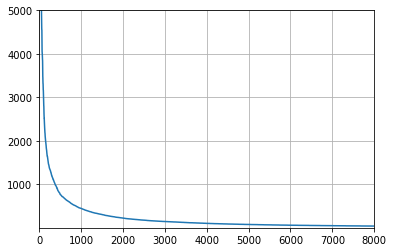

In [8]:
plt.plot(word_num, frequency)
plt.grid()
plt.axis([0,8000, 1, 5000])
plt.show()

In [9]:
print("Highest frequency of a word in vacabulary is :",vocab[0][1])
print("Lowest frequency of a word in vacabulary is :",vocab[len(vocab)-1][1])
print("Length of vocab is:",len(vocab))

Highest frequency of a word in vacabulary is : 123562
Lowest frequency of a word in vacabulary is : 1
Length of vocab is: 93499


 ### We consisder top 2000 words only bcz as we increase words, frequency decreases as we see in above plot. Even word at 2000 index having frequecy less than 500. So in training matrix which we create , column corresponding to this word will contain mostly zeros. So no need to add furher words bcz they will not affect the results.

In [10]:
ind=2000

#### new vocab --> Consisder only top ind words

In [11]:
'''
    create dictionary bcz it will be easy to check word present or not. 
    If we use list, then everytime we need to traverse to find paticular word present in list or not
''' 
Vocab = {}
for i in range(ind):
    w=vocab[i][0]
    f=vocab[i][1]
    Vocab[w]=f

#### create features dictionary - we use words as features

In [12]:
features = {}
for i in range(ind):
    w_i = vocab[i][0]
    features[w_i] = i

### Now we create X_train, Y_train, X_test and Y_test

In [13]:
X_train = np.zeros((len(x_train),ind), dtype='uint8')
Y_train = np.empty(len(y_train), dtype='<U30') # max size of string is 30

X_test = np.zeros((len(x_test),ind), dtype='uint8')
Y_test = np.empty(len(y_test), dtype='<U30') # max size of string is 30

In [14]:
# X_train and X_test
total_training_doc = len(x_train)
for i in range(total_training_doc):
    stripped_words = re.split(r'\W+',x_train[i]) ## using regular expressions
    for word in stripped_words:
        # check if word is present in Vocab and word is also used as a feature
        if Vocab.get(word.lower(), None) is not None and features.get(word.lower(),None) is not None:
            col = features[word.lower()]
            X_train[i][col] += 1 # Increase frequency corresponding to word in document i
            
    # store corresponding newsgroup (label)
    Y_train[i] = y_train[i]

In [15]:
# X_test and Y_test
total_testing_doc = len(x_test)
for i in range(total_testing_doc):
    stripped_words = re.split(r'\W+',x_test[i]) ## using regular expressions
    for word in stripped_words:
        # check if word is present in Vocab and word is also used as a feature
        if Vocab.get(word.lower(), None) is not None and features.get(word.lower(),None) is not None:
            col = features[word.lower()]
            X_test[i][col] += 1 # Increase frequency corresponding to word in document i
            
    # store corresponding newsgroup (label)
    Y_test[i] = y_test[i]

# Functions used for creating our own Multinomial Naive Bayes

In [16]:
# fit fnction returns a dictionary
def fit(X_train, Y_train):
    count = {}
    vocab_size = 0  # total number of words present in Vocab
    count["total_data"] = len(Y_train) # total number of documents
    class_values = set(Y_train)
    for current_class in class_values:
        count[current_class] = {}
        current_class_rows = (Y_train == current_class)
        
        # Get X_train corresponding to current_class
        X_train_current = X_train[current_class_rows]
        Y_train_current = Y_train[current_class_rows]
        
        # total no. of documents of current_class
        count[current_class]["current_class_count"] = len(Y_train_current)
        
        # Iterate over all words and store its frequency
        num_features = X_train.shape[1]
        total_current_class_words = 0
        for j in range(1, num_features + 1):
            # store frequency of j th word(feature) corresponding to current_class 
            count[current_class][j] = X_train_current[:, j-1].sum()
            total_current_class_words += X_train_current[:, j-1].sum()
            
        # store total words of a current_class also
        count[current_class]["total_count"] = total_current_class_words
        vocab_size += total_current_class_words
    count["vocab_size"] = vocab_size
    return count # returns dictionary created

We need to calculate log( P(X=x | y=current_class) ) + log( P(y=current_class) )
        
Assuming independent events:
P(X=x | y=current_class) = P(w1|y=current_class) * P(w2|y=current_class) *
                                    P(w3|y=current_class) * ....
        
        
Therefore, log( P(X=x | y=current_class) ) = log( P(w1|y=current_class) )
                                                                +
                                             log( P(w2|y=current_class) )
                                                                +
                                             log( P(w3|y=current_class) )
                                                                +
                                                                .
                                                                .
                                                                .

In [17]:
def probability(dictionary, x, current_class):
    #  log( P(y=current_class) )
    output = np.log(dictionary[current_class]['current_class_count']) - np.log(dictionary["total_data"]) 
    
    num_features = len(dictionary[current_class].keys()) - 2  # -2 bcz 2 keys are total_count and current_class_count
    for j in range(1,num_features+1):
        xj = x[j-1]
        if xj == 0: # word not in test data document
            continue
            
        '''
            word is present as a feature. So add its corresponding logarithmic probability
            Also use laplace correction i.e
            log( P(w1|y=current_class) ) = log( count of all w1 corresponding 
                                                to current_class + 1)
                                                      -
                                            log( count of all words of current_class
                                                 + size of vocabulary)
        '''  
        count_jth_word_in_current_class = dictionary[current_class][j] + 1  # +1 bcz of laplace correction
        count_current_class = dictionary[current_class]["total_count"] + dictionary["vocab_size"]
        count_xj_probability = np.log(count_jth_word_in_current_class) - np.log(count_current_class)
        output = output + count_xj_probability
    
    return output

In [18]:
def predictSinglePoint(dictionary, x):
    classes = dictionary.keys()
    best_p = -1000   # Initially
    best_class = -1
    first_run = True  # Bcz best_p should be changed for the first time
    for current_class in classes:
        if current_class == "vocab_size" or current_class=="total_data":
            continue
            
        # Find logarithmic probability of current_class
        p_current_class = probability(dictionary, x, current_class)
        if (first_run or p_current_class > best_p):
            best_p = p_current_class
            best_class = current_class
        first_run = False  # bcz we done for 1st time
    return best_class

In [19]:
def predict(dictionary, X_test):
    y_pred = []
    for x in X_test:
        x_class = predictSinglePoint(dictionary, x)
        y_pred.append(x_class)
    return y_pred

## Find predictions using our own Multinomial classifier

In [20]:
dictionary = fit(X_train, Y_train)

In [21]:
Y_pred = predict(dictionary, X_test)

In [22]:
print(confusion_matrix(Y_test, Y_pred))

[[176   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   1
   10  45]
 [  0 184   2   7   0  34   0   0   0   0   0  17   0   0   1   0   0   0
    8   0]
 [  0  23 113   9   0  75   0   0   0   0   0  18   0   0   1   0   1   0
    9   0]
 [  0   8   1 204   3   8   2   0   0   0   0  10   0   0   0   0   0   0
    4   0]
 [  0   6   1  42 152  15   2   0   0   0   0  10   1   0   0   0   1   1
    5   0]
 [  0   8   4   3   0 218   1   0   0   0   0   4   0   0   0   0   0   0
    2   0]
 [  0   1   1  18   0   1 180   3   0   0   0   6   7   0   2   0   1   0
   41   0]
 [  0   1   0   0   0   1   5 190   0   0   1   2   3   1   1   0  25   2
   37   0]
 [  4   1   0   0   0   0   1  11 166   0   0   8   0   1   0   0  24   2
   66   0]
 [  0   0   0   0   0   0   0   0   0 190  26   0   0   0   1   0   1   1
   29   0]
 [  0   0   0   0   0   0   0   0   0   0 221   0   0   0   0   0   1   0
    9   0]
 [  0   1   0   0   0   0   0   0   0   0   0 229   0   0   0   0

In [23]:
print(classification_report(Y_test, Y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.76      0.78       233
           comp.graphics       0.75      0.73      0.74       253
 comp.os.ms-windows.misc       0.93      0.45      0.61       249
comp.sys.ibm.pc.hardware       0.71      0.85      0.78       240
   comp.sys.mac.hardware       0.98      0.64      0.78       236
          comp.windows.x       0.62      0.91      0.73       240
            misc.forsale       0.94      0.69      0.80       261
               rec.autos       0.93      0.71      0.80       269
         rec.motorcycles       1.00      0.58      0.74       284
      rec.sport.baseball       0.99      0.77      0.87       248
        rec.sport.hockey       0.89      0.96      0.92       231
               sci.crypt       0.60      0.98      0.75       233
         sci.electronics       0.93      0.56      0.70       244
                 sci.med       0.98      0.67      0.80       256
         

## Using inbuilt Multinomial Naive Bayes classifier

In [24]:
clf = MultinomialNB()

In [25]:
clf.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
Y_pred = clf.predict(X_test)

In [27]:
print(confusion_matrix(Y_test, Y_pred))

[[195   0   0   0   0   0   0   4   1   0   0   0   0   1   0   1   0   0
    0  31]
 [  0 199  16  21   3   8   2   2   0   1   0   0   0   1   0   0   0   0
    0   0]
 [  0   6 210  13   4   9   3   1   0   0   0   0   2   1   0   0   0   0
    0   0]
 [  0   1   3 196  32   0   5   0   1   0   0   0   2   0   0   0   0   0
    0   0]
 [  0   2   1  23 204   0   5   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0  15  30  13   5 165   3   0   2   1   0   1   2   1   2   0   0   0
    0   0]
 [  0   0   1   7   3   0 236   5   1   0   1   0   5   0   1   0   1   0
    0   0]
 [  0   0   0   1   1   0  11 247   3   1   1   0   4   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   2   4 277   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   2   4   2 227  12   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   2   7 221   0   0   0   1   0   0   0
    0   0]
 [  0   3   0   0   0   2   1   0   0   0   0 224   2   1   0   0

In [28]:
print(classification_report(Y_test, Y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.84      0.82       233
           comp.graphics       0.85      0.79      0.82       253
 comp.os.ms-windows.misc       0.80      0.84      0.82       249
comp.sys.ibm.pc.hardware       0.68      0.82      0.74       240
   comp.sys.mac.hardware       0.78      0.86      0.82       236
          comp.windows.x       0.89      0.69      0.78       240
            misc.forsale       0.85      0.90      0.87       261
               rec.autos       0.88      0.92      0.90       269
         rec.motorcycles       0.91      0.98      0.94       284
      rec.sport.baseball       0.92      0.92      0.92       248
        rec.sport.hockey       0.93      0.96      0.94       231
               sci.crypt       0.96      0.96      0.96       233
         sci.electronics       0.89      0.88      0.88       244
                 sci.med       0.94      0.86      0.89       256
         

## Comparison between inbuilt and our own built classifier

#### From above results we see that inbuilt Multinomial naive bayes has acuuracy of 86%. 
#### Where as accuracy achieved by using our own Multinomial classifier is 75%